# Importing required Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import geopandas as gpd
from geopandas.tools import geocode
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [4]:
# plotly for offline use
import plotly
plotly.offline.init_notebook_mode(connected=True)

# Utility Functions

In [5]:
def plot_cal(title, start, end):
    '''Plot incubation period'''
    inc_day = []
    for i in range(1, 29):
        if(i>=start and i<=end):
            inc_day.append(1)
        else:
            inc_day.append(0)
            
    inc_day = np.array(inc_day)
    inc_day = inc_day.reshape(4, 7)
    
    fig, ax = plt.subplots(figsize=(6, 3))
    ax=sns.heatmap(inc_day, linewidths=2, square=True, 
                   xticklabels='', yticklabels='', ax=ax,
                   cbar=False, cmap=['whitesmoke','royalblue'])
    ax.set_title(title, fontdict={'fontsize':16}, loc='left', pad=15)
    
    plt.show()

In [6]:
def plot_barh(col):
    
    temp_df = latest.sort_values(col, ascending=False).head(10)
    temp_df = temp_df[temp_df[col]!=0]
    
    hover_data = ['Cumulative total cases', 'No. of deaths', 'Case fatalities ratio (%)']
    
    fig =  px.bar(temp_df, x=col, y='Country/Region', orientation='h', color='Country/Region', 
                  text=col, title=col, width=700, hover_data = hover_data,
                  color_discrete_sequence = px.colors.qualitative.Dark2)
    fig.update_traces(textposition='auto')
    fig.update_layout(xaxis_title="", yaxis_title="", showlegend=False,
                      uniformtext_minsize=8, uniformtext_mode='hide')
    fig.show()

In [7]:
def plot_pie(col1, col2, title, pal):

    temp = latest[[col1, col2]].sum()
    temp = pd.DataFrame(temp).reset_index()
    temp.columns = ['Column', 'Value']
    
    fig = px.sunburst(temp, path=['Column'], values='Value',
                      color_discrete_sequence=pal, title=title)
    fig.data[0].textinfo = 'label+text+value+percent root'
    fig.show()

# Dataset

### List of files

In [8]:
# list of files
!ls -lt ../input/sars-outbreak-2003-complete-dataset

ls: ../input/sars-outbreak-2003-complete-dataset: No such file or directory


### Import files

In [11]:
# importing daywise dataset
df = pd.read_csv('/Users/pranjal27bhardwaj/Desktop/sars/Datasets/sars_2003_complete_dataset_clean.csv', parse_dates=['Date'])
# rename columns
df.columns = ['Date', 'Country', 'Cases', 'Deaths', 'Recovered']
# active no. of cases
df['Active'] = df['Cases'] - df['Deaths'] - df['Recovered']
# first few rows
df.head()

Date               Country  Cases  Deaths  Recovered  Active
0 2003-03-17               Germany      1       0          0       1
1 2003-03-17                Canada      8       2          0       6
2 2003-03-17             Singapore     20       0          0      20
3 2003-03-17  Hong Kong SAR, China     95       1          0      94
4 2003-03-17           Switzerland      2       0          0       2

In [12]:
# day wise data
day_wise = df.groupby(['Date'])['Cases', 'Deaths', 'Recovered', 'Active'].sum()
# reset index
day_wise = day_wise.reset_index()
# first few rows
day_wise.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



Date  Cases  Deaths  Recovered  Active
0 2003-03-17    167       4          0     163
1 2003-03-18    219       4          0     215
2 2003-03-19    264       9          0     255
3 2003-03-20    306      10          0     296
4 2003-03-21    350      10          0     340

In [16]:
# importing summary dataset
latest = pd.read_csv('/Users/pranjal27bhardwaj/Desktop/sars/Datasets/summary_data_clean.csv')
# fix datetime columns
cols = ['Date onset first probable case', 'Date onset last probable case']
for col in cols:
    latest[col] = pd.to_datetime(latest[col])
cols = ['Number of Imported cases', 'Percentage of Imported cases']
for col in cols:
    latest[col] = latest[col].fillna(0)
# new columns
latest['Number of locally transmitted cases'] = latest['Cumulative total cases'] - latest['Number of Imported cases']
latest['Percentage of locally transmitted cases'] = 100 - latest['Percentage of Imported cases']
latest['Number of non HCW affected'] = latest['Cumulative total cases'] - latest['Number of HCW affected']
latest['Percentage of non HCW affected'] = 100 - latest['Percentage of HCW affected']
latest['Non fatality case (%)'] = 100 - latest['Case fatalities ratio (%)']
latest['No. of recovered'] = latest['Cumulative total cases'] - latest['No. of deaths']

# first few rows
latest.head()

Country/Region  Cumulative male cases  Cumulative female cases  \
0             Australia                      4                        2   
1                Canada                    151                      100   
2                 China                   2674                     2607   
3  Hong Kong SAR, China                    977                      778   
4      Macao SAR, China                      0                        1   

   Cumulative total cases  No. of deaths  Case fatalities ratio (%)  \
0                       6              0                          0   
1                     251             43                         17   
2                    5327            349                          7   
3                    1755            299                         17   
4                       1              0                          0   

  Date onset first probable case Date onset last probable case  Median age  \
0                     2003-02-26                    2003-04-01        15.0   
1                     2003-02-23                    2003-06-12        49.0   
2                     2002-11-16                    2003-06-03         NaN   
3                     2003-02-15                    2003-05-31        40.0   
4                     2003-05-05                    2003-05-05        28.0   

  Age range  Number of Imported cases  Percentage of Imported cases  \
0      1-45                       6.0                         100.0   
1      1-98                       5.0                           2.0   
2       NaN                       0.0                           0.0   
3     0-100                       0.0                           0.0   
4       NaN                       1.0                         100.0   

   Number of HCW affected  Percentage of HCW affected  \
0                       0                           0   
1                     109                          43   
2                    1002                          19   
3                     386                          22   
4                       0                           0   

   Number of locally transmitted cases  \
0                                  0.0   
1                                246.0   
2                               5327.0   
3                               1755.0   
4                                  0.0   

   Percentage of locally transmitted cases  Number of non HCW affected  \
0                                      0.0                           6   
1                                     98.0                         142   
2                                    100.0                        4325   
3                                    100.0                        1369   
4                                      0.0                           1   

   Percentage of non HCW affected  Non fatality case (%)  No. of recovered  
0                             100                    100                 6  
1                              57                     83               208  
2                              81                     93              4978  
3                              78                     83              1456  
4                             100                    100                 1

In [19]:
# load countries map
world_map = gpd.read_file('/Users/pranjal27bhardwaj/Desktop/sars/Humandevelopemnt/countries.geojson')
# avoid Antartica
world_map = world_map[world_map['name']!='Antarctica']
# select only important columns
world_map = world_map[['name', 'continent', 'geometry']]
# first few rows
world_map.head()

name      continent  \
0        Aruba  North America   
1  Afghanistan           Asia   
2       Angola         Africa   
3     Anguilla  North America   
4      Albania         Europe   

                                            geometry  
0  POLYGON ((-69.89912 12.45200, -69.89570 12.423...  
1  POLYGON ((74.89131 37.23164, 74.84023 37.22505...  
2  MULTIPOLYGON (((14.19082 -5.87598, 14.39863 -5...  
3  POLYGON ((-63.00122 18.22178, -63.16001 18.171...  
4  POLYGON ((20.06396 42.54727, 20.10352 42.52466...

## SARS (Severe Acute Respiratory Syndrome)

### Cause
> * SARS coronavirus (SARS-CoV) – virus identified in **2003**. 
> * SARS-CoV is thought to be an animal virus from an as-yet-uncertain animal reservoir, perhaps **bats**, that spread to other animals (**civet cats**)
> * It was first infected humans in the **Guangdong province of southern China** in **2002**.

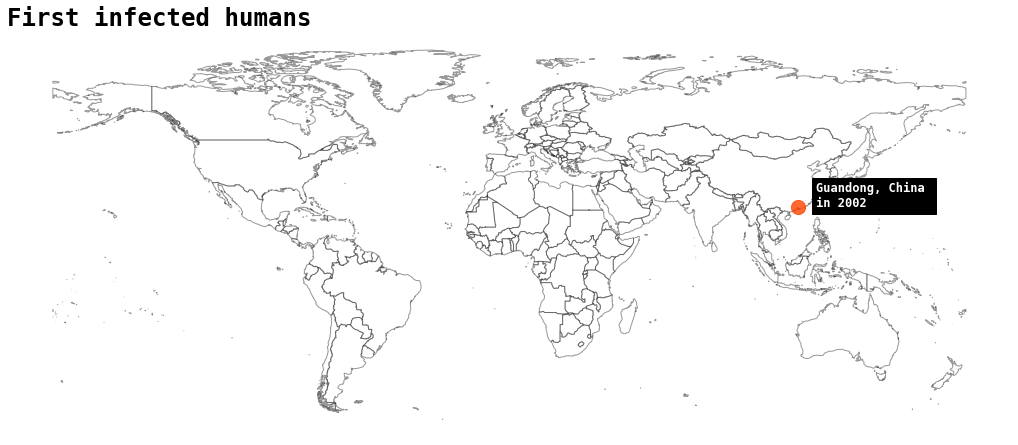

In [21]:
fig, ax = plt.subplots(figsize=(18, 14))
sns.set_style('whitegrid')

world_map.plot(ax=ax, color='white', edgecolor='black', alpha=0.4)
ax.set_title('First infected humans', 
             loc='left', fontdict={'fontsize': 24, 
                                   'fontfamily': 'monospace', 
                                   'fontweight': 'bold',
                                   'color': 'black'})

ax.scatter(113.7633, 23.3790, color='orangered', s=200, alpha=0.8)
ax.text(120.7633, 23.3790, 'Guandong, China \nin 2002', 
        fontfamily='monospace', fontsize=12, fontweight='bold',
        color='white', backgroundcolor='black')

ax.set_axis_off()

### Transmission
> * Transmission of SARS-CoV is primarily from person to person. 
> * It appears to have occurred mainly during the second week of illness, which corresponds to the peak of virus excretion in respiratory secretions and stool, and when cases with severe disease start to deteriorate clinically. 
> * Most cases of human-to-human transmission occurred in the health care setting, in the absence of adequate infection control precautions. 
> * Implementation of appropriate infection control practices brought the global outbreak to an end.

### Symptoms
> * Influenza-like and include fever
> * Malaise
> * Myalgia
> * Headache
> * Diarrhoea, and
> * Shivering (rigors). 

### Nature of the disease
> * No individual symptom or cluster of symptoms has proved to be specific for a diagnosis of SARS. 
> * Although fever is the most frequently reported symptom, it is sometimes absent on initial measurement, especially in elderly and immunosuppressed patients.
> * Cough (initially dry), shortness of breath, and diarrhoea are present in the first and/or second week of illness. 
> * Severe cases often evolve rapidly, progressing to respiratory distress and requiring intensive care.

### Vaccines
> * None. Experimental vaccines are under development.

### Incubation period (time interval from infection with the virus to onset of symptoms)
> * Incubation period of SARS-CoV is from 2 to 7 days. 
> * A person infected with SARS-CoV cannot spread the disease until they develop symptoms.

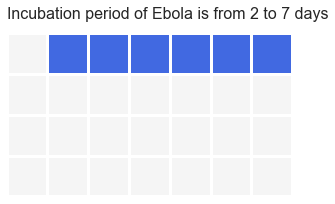

In [22]:
plot_cal('Incubation period of Ebola is from 2 to 7 days', 2, 7)

### Geographical distribution
> * The disease appeared in November 2002 in the Guangdong province of southern China. 
> * This area is considered as a potential zone of re-emergence of SARS-CoV.
> * SARS-CoV affected 26 countries and resulted in more than 8000 cases in 2003

In [23]:
fig = px.choropleth(latest, locations="Country/Region", locationmode='country names',
                    color="Cumulative total cases", hover_name="Country/Region", 
                    color_continuous_scale="Sunset", 
                    title='Choropleth map cumulative no. of cases')
fig.update(layout_coloraxis_showscale=True)
fig.show()

# EDA

## Country wise summary

In [24]:
plot_barh('Cumulative total cases')

In [25]:
plot_barh('No. of deaths')

In [26]:
plot_barh('Case fatalities ratio (%)')

### Imported Cases

In [27]:
plot_barh('Number of Imported cases')

### Health Care Workers

In [28]:
plot_barh('Number of HCW affected')

In [29]:
plot_pie('No. of deaths', 'No. of recovered', 'CFR', ['lightseagreen', 'orangered'])

In [30]:
plot_pie('Cumulative male cases', 'Cumulative female cases', 'Gender wise', ['royalblue', 'crimson'])

In [31]:
plot_pie('Number of HCW affected', 'Number of non HCW affected', 'HCW', ['whitesmoke', 'dodgerblue'])

In [32]:
plot_pie('Number of Imported cases', 'Number of locally transmitted cases', 'Imported cases', ['slateblue', 'gold'])

### Onset Date

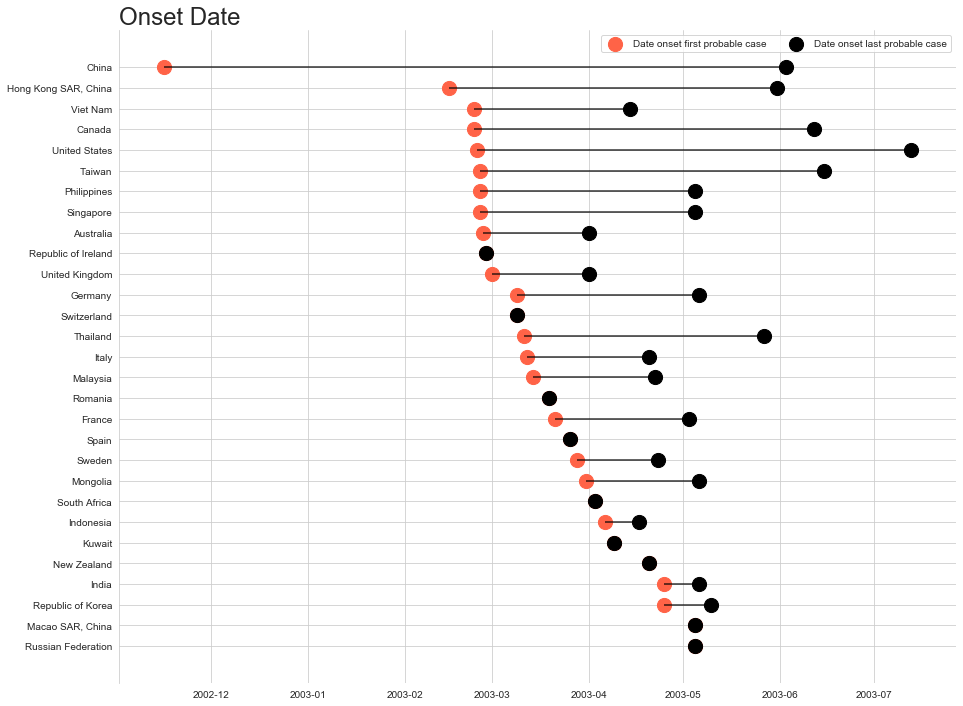

In [33]:
latest = latest.sort_values('Date onset first probable case', ascending=False)

country = latest['Country/Region']
start = latest['Date onset first probable case'].to_numpy()
end = latest['Date onset last probable case'].to_numpy()

sns.set_style('whitegrid')
plt.figure(figsize=(15, 12))

plt.hlines(y=country, xmin=start, xmax=end, color='black', alpha=0.8)
plt.scatter(start, country, color='tomato', alpha=1, s=200, label='Date onset first probable case')
plt.scatter(end, country, color='black', alpha=1 , s=200, label='Date onset last probable case')

sns.despine(left=False, bottom=True)
plt.title('Onset Date', loc='left', fontsize=24)
plt.legend(ncol=2)
plt.show()

### Age Range

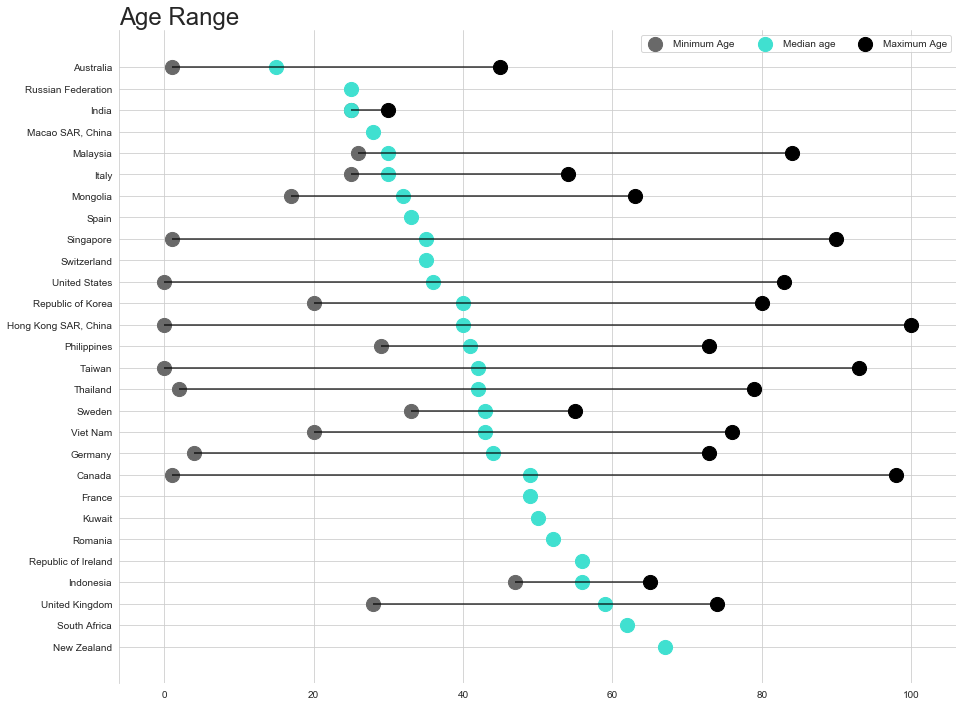

In [34]:
age = latest[['Country/Region', 'Median age', 'Age range']]
age = age.sort_values('Median age', ascending=False)
age = age.dropna(subset=['Median age'])        

age['Min age'] = age['Age range'].str.extract('(\d+)')
age['Max age'] = age['Age range'].str.extract('\-(\d+)')

for col in ['Median age', 'Min age', 'Max age']:
    age[col] = pd.to_numeric(age[col])

country = age['Country/Region']
median_age = pd.to_numeric(age['Median age'])
min_age = pd.to_numeric(age['Min age'])
max_age = pd.to_numeric(age['Max age'])

sns.set_style('whitegrid')
plt.figure(figsize=(15, 12))

plt.hlines(y=country, xmin=min_age, xmax=max_age, color='black', alpha=0.8)
plt.scatter(min_age, country, color='dimgray', alpha=1, s=200, label='Minimum Age')
plt.scatter(median_age, country, color='turquoise', alpha=1, s=200, label='Median age')
plt.scatter(max_age, country, color='black', alpha=1 , s=200, label='Maximum Age')

sns.despine(left=False, bottom=True)
plt.title('Age Range', loc='left', fontsize=24)
plt.legend(ncol=3)
plt.show()

# Day wise

In [35]:
def plot_daywise(col, hue):
    temp = day_wise[day_wise['Date'] > '2003-04-12']
    fig = px.area(temp, x="Date", y=col, width=700, 
                  color_discrete_sequence=[hue])
    fig.update_layout(title=col, xaxis_title="", yaxis_title="")
    fig.show()

In [36]:
def plot_stacked(col):
    temp = df[df['Date'] > '2003-04-12']
    fig = px.area(temp, x="Date", y=col, color='Country', 
                 height=600, title=col, 
                 color_discrete_sequence = px.colors.cyclical.mygbm)
    fig.update_layout(showlegend=True)
    fig.show()

In [37]:
plot_daywise('Cases', 'black')

In [38]:
plot_daywise('Deaths', 'orangered')

In [39]:
plot_daywise('Recovered', 'limegreen')

In [40]:
plot_daywise('Active', 'crimson')

In [41]:
plot_stacked('Cases')

In [42]:
plot_stacked('Deaths')

In [43]:
plot_stacked('Recovered')

In [44]:
plot_stacked('Active')

In [45]:
# temp = df.groupby('Date')['Recovered', 'Deaths', 'Active'].sum().reset_index()
# temp = temp.melt(id_vars="Date", value_vars=['Recovered', 'Deaths', 'Active'],
#                  var_name='Case', value_name='Count')
# temp.head()

# # fig = px.area(temp, x="Date", y="Count", color='Case', 
#               height=600, width=700, title='Cases over time', 
#               color_discrete_sequence = ['limegreen', 'crimson', 'black'])
# fig.update_layout(xaxis_rangeslider_visible=True)
# fig.show()

In [46]:
temp = latest[['Country/Region', 'Cumulative male cases', 'Cumulative female cases']]
temp['% Male'] = temp['Cumulative male cases']*100/(temp['Cumulative male cases']+temp['Cumulative female cases'])
temp['% Female'] = temp['Cumulative female cases']*100/(temp['Cumulative male cases']+temp['Cumulative female cases'])
temp.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Country/Region  Cumulative male cases  Cumulative female cases  \
19  Russian Federation                      0                        1   
4     Macao SAR, China                      0                        1   
17   Republic of Korea                      0                        3   
8                India                      0                        3   
14         New Zealand                      1                        0   

    % Male  % Female  
19     0.0     100.0  
4      0.0     100.0  
17     0.0     100.0  
8      0.0     100.0  
14   100.0       0.0

In [47]:
temp1 = temp.melt(id_vars='Country/Region', 
                 value_vars=['Cumulative male cases', 'Cumulative female cases'], 
                 var_name='Case', value_name='Count')
temp1 = temp1.sort_values(['Count'], ascending=True)


fig = px.bar(temp1, x='Count', y='Country/Region', color='Case', 
             opacity=1, orientation='h', height=600,
             barmode='stack',
             color_discrete_sequence=['indigo', 'deeppink'])
fig.update_layout(title='No. of case based on Gender', xaxis_title="", yaxis_title="")
fig.show()

In [48]:
temp2 = temp.melt(id_vars='Country/Region', 
                 value_vars=['% Male', '% Female'], 
                 var_name='Case', value_name='Percentage')
temp2 = temp2.sort_values(['Percentage'], ascending=True)

fig = px.bar(temp2, x='Percentage', y='Country/Region', color='Case', 
             opacity=1, orientation='h', height=600,
             barmode='stack',
             color_discrete_sequence=['indigo', 'deeppink'])
fig.update_layout(title='No. of case based on Gender', xaxis_title="", yaxis_title="")
fig.show()

In [49]:
def plot_overlay_bar(col, hue):
    temp = latest[['Country/Region', 'Cumulative total cases', col]]
    temp = temp.melt(id_vars='Country/Region', 
                     value_vars=['Cumulative total cases', col], 
                     var_name='Case', value_name='Count')
    temp = temp.sort_values(['Case', 'Count'], ascending=True)
    
    fig = px.bar(temp, x='Count', y='Country/Region', color='Case', 
                 opacity=1, orientation='h', height=600,
                 barmode='overlay',
                 color_discrete_sequence=['black', hue])
    fig.update_layout(title=col, xaxis_title="", yaxis_title="")
    fig.show()

In [50]:
def plot_overlay_percent_bar(col1, col2, hue):
    temp = latest[['Country/Region', col1, col2]]
    temp = temp.melt(id_vars='Country/Region', 
                     value_vars=[col1, col2], 
                     var_name='Case', value_name='Percentage')
    temp = temp.sort_values(['Case', 'Percentage'], ascending=True)
    
    fig = px.bar(temp, x='Percentage', y='Country/Region', color='Case', 
                 opacity=1, orientation='h', height=600,
                 barmode='stack', range_x=[0,100],
                 color_discrete_sequence=[hue, 'black'])
    fig.update_layout(title=col1, xaxis_title="", yaxis_title="")
    fig.show()

In [51]:
plot_overlay_bar('No. of deaths', 'orangered')

In [52]:
plot_overlay_percent_bar('Case fatalities ratio (%)', 'Non fatality case (%)', 'orangered')

In [53]:
plot_overlay_bar('Number of Imported cases', 'gold')

In [54]:
plot_overlay_percent_bar('Percentage of Imported cases', 'Percentage of locally transmitted cases', 'gold')

In [55]:
plot_overlay_bar('Number of HCW affected', 'cornflowerblue')

In [56]:
plot_overlay_percent_bar('Percentage of HCW affected', 'Percentage of non HCW affected', 'cornflowerblue')